In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import catboost
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle

SEED = 42

In [2]:
def compute_metric(df):
    df = df.set_index('dt') 
    tender_price = df['Цена на арматуру']
    decision = df['Объем']
    start_date = df.index.min()
    end_date = df.index.max()
    _results = []
    _active_weeks = 0
    for report_date in pd.date_range(start_date, end_date, freq='W-MON'):
        if _active_weeks == 0:  # Пришла пора нового тендера
            _fixed_price = tender_price.loc[report_date]
            _active_weeks = int(decision.loc[report_date])
        _results.append(_fixed_price)
        _active_weeks += -1
    cost = sum(_results)
    return cost

In [3]:
def add_info(df):
    sirie = pd.read_excel('data/Цены на сырье.xlsx')
    sirie = sirie[sirie.dt.isin(df.dt)].dropna(axis=1)
    sirie.columns = [f'сырье_{x}' if sirie.columns[x]!='dt' else 'dt' for x in range(len(sirie.columns))]
    df = df.merge(sirie, how='left', on='dt')

    # Индекс стоимости грузоперевозок
    # Данные предоставляются по средам, но чтобы их учитывать в тендерах
    # мы меняем их дату на следующий понедельник
    gruz = pd.read_excel('data/Грузоперевозки.xlsx')
    gruz = pd.concat((gruz, df[['dt']])).sort_values('dt')
    gruz['Индекс стоимости грузоперевозок'] = gruz['Индекс стоимости грузоперевозок'].shift(1)
    gruz = gruz[gruz.dt.isin(df.dt)]
    df = df.merge(gruz, how='left', on='dt')

    # Данные у нас предоставляется в последний день каждого месяца
    # Меняем дату на следующие понедельник
    # Т.е. в понедельник определенного месяца будут одни и те же 
    metall = pd.read_excel('data/Показатели рынка металла.xlsx')
    metall = pd.concat((metall, df[~df.dt.isin(metall.dt)][['dt']])).sort_values('dt')
    metall = metall.fillna(method='ffill')
    metall = metall[metall.dt.isin(df.dt)]
    metall.columns = [f'металл_{x}' if metall.columns[x] != 'dt' else 'dt' for x in range(len(metall.columns))]
    df = df.merge(metall, how='left', on='dt')
    
    # То же самое, что и с показателями ранка металла
    materials = pd.read_excel('data/Данные рынка стройматериалов.xlsx') # То же, пока что только по месяцам, надо по дням
    materials = pd.concat((materials, df[~df.dt.isin(materials.dt)][['dt']])).sort_values('dt')
    materials = materials.fillna(method='ffill')
    materials = materials[materials.dt.isin(df.dt)].dropna()
    materials.columns = [f'материалы_{x}' if materials.columns[x] != 'dt' else 'dt' for x in range(len(materials.columns))]
    df = df.merge(materials, how='left', on='dt')
    
    # То же самое
    toplivo = pd.read_excel('data/Топливо.xlsx')
    toplivo = pd.concat((toplivo, df[~df.dt.isin(toplivo.dt)][['dt']])).sort_values('dt')
    toplivo = toplivo.fillna(method='ffill')
    toplivo = toplivo[toplivo.dt.isin(df.dt)].dropna()
    toplivo.columns = [f'топливо_{x}' if toplivo.columns[x] != 'dt' else 'dt' for x in range(len(toplivo.columns))]
    df = df.merge(toplivo, how='left', on='dt')
    
    # И опять:)
    lme = pd.read_excel('data/Индекс LME.xlsx').rename({'дата':'dt', 'цена': 'индекс lme'}, axis=1).dropna()
    lme = pd.concat((lme, df[~df.dt.isin(lme.dt)][['dt']])).sort_values('dt')
    lme = lme.fillna(method='ffill')
    lme = lme[lme.dt.isin(df.dt)].dropna()
    df = df.merge(lme, how='left', on='dt')
    
    # Берем цену акции, считаем как изменилась цена за предыдущую неделю
    chmf_stock = pd.read_csv(
        'data/CHMF Акции.csv',
        parse_dates=['Date']
    )[['Date', 'Change %']].rename({
        'Date': 'dt',
        'Change %': 'chmf_change'
    }, axis=1)
    chmf_stock['chmf_change'] = chmf_stock['chmf_change'].str.replace('%', '').astype(np.float32) / 100 + 1
    # Собираем информацию по изменению цены за предыдущие 5 дней
    chmf_stock['chmf_change'] = chmf_stock.chmf_change *\
        chmf_stock.chmf_change.shift(-1) *\
        chmf_stock.chmf_change.shift(-2) *\
        chmf_stock.chmf_change.shift(-3) *\
        chmf_stock.chmf_change.shift(-4)
    # Берем данные за пятницу и меняем дату на следующий понедельник, когда будет проводиться тендер
    chmf_stock = chmf_stock[chmf_stock.dt.dt.day_of_week == 4].dropna()
    chmf_stock = pd.concat((chmf_stock, df[~df.dt.isin(chmf_stock.dt)][['dt']])).sort_values('dt')
    chmf_stock = chmf_stock.fillna(method='ffill')
    chmf_stock = chmf_stock[chmf_stock.dt.isin(df.dt)].dropna()
    df = df.merge(chmf_stock, how='left', on='dt')
    
    # То же самое
    magn_stock = pd.read_csv(
        'data/MAGN Акции.csv',
        parse_dates=['Дата']
    )[['Дата', 'Изм. %']].rename({
        'Дата': 'dt',
        'Изм. %': 'magn_change'
    }, axis=1)
    magn_stock['magn_change'] = magn_stock['magn_change'].str.replace('%', '').str.replace(',','.').astype(np.float32)/100+1
    magn_stock['magn_change'] = magn_stock.magn_change *\
        magn_stock.magn_change.shift(-1) *\
        magn_stock.magn_change.shift(-2) *\
        magn_stock.magn_change.shift(-3) *\
        magn_stock.magn_change.shift(-4)
    magn_stock = magn_stock[magn_stock.dt.dt.day_of_week == 4].dropna()
    magn_stock = pd.concat((magn_stock, df[~df.dt.isin(magn_stock.dt)][['dt']])).sort_values('dt')
    magn_stock = magn_stock.fillna(method='ffill')
    magn_stock = magn_stock[magn_stock.dt.isin(df.dt)].dropna()
    df = df.merge(magn_stock, how='left', on='dt')
    
    # То же самое:)
    nlmk_stock = pd.read_csv(
        'data/NLMK Акции.csv',
        parse_dates=['Date']
    )[['Date', 'Change %']].rename({
        'Date': 'dt',
        'Change %': 'nlmk_change'
    }, axis=1)
    nlmk_stock['nlmk_change'] = nlmk_stock['nlmk_change'].str.replace('%', '').str.replace(',','.').astype(np.float32)/100+1
    nlmk_stock['nlmk_change'] = nlmk_stock.nlmk_change *\
        nlmk_stock.nlmk_change.shift(-1) *\
        nlmk_stock.nlmk_change.shift(-2) *\
        nlmk_stock.nlmk_change.shift(-3) *\
        nlmk_stock.nlmk_change.shift(-4)
    nlmk_stock = nlmk_stock[nlmk_stock.dt.dt.day_of_week == 4].dropna()
    nlmk_stock = pd.concat((nlmk_stock, df[~df.dt.isin(nlmk_stock.dt)][['dt']])).sort_values('dt')
    nlmk_stock = nlmk_stock.fillna(method='ffill')
    nlmk_stock = nlmk_stock[nlmk_stock.dt.isin(df.dt)].dropna()
    df = df.merge(nlmk_stock, how='left', on='dt')


    df['Изменение цены на арматуру'] = df['Цена на арматуру']/df['Цена на арматуру'].shift(1)
    df['month'] = df.dt.dt.month
    df = df.dropna(axis=1, how='all')

    return df


def make_features(df):
    """Создание фичей по имеющимся у нас данным

    Args:
        df : Данные, которые у нас имеются для рекомендации к тендеру

    Returns:
        list: Список из фичей, которые достали из данных
    """
    cur_values = []

    # Как в последние 18 недель изменялась цена на арматуру
    cur_change = df['Изменение цены на арматуру'][-18:].tolist()
    cur_values.append(cur_change)
    
    # Во сколько раз изменилась цена на арматуру за последние 18 недель
    a = 1
    for x in cur_change:
        a *= x
    cur_values.append([a])
    
    # Средняя цена на арматуру в последние 10 недель
    cur_values.append([
        np.mean(df['Цена на арматуру'][-10:])
    ])
    cur_values.append([df['Изменение в месяце'].tolist()[-1]])

    # Для каждой колонке из таблицы "Цены на сырье" вычисляем во сколько раз изменилась
    # цена за последние 1,2 месяца и за последнюю неделю
    cur_values.append([df[x].tolist()[-1]/df[x].tolist()[-10] if df[x].tolist()[-10]!=0 else np.nan
                       for x in df.columns if 'сырье' in x])
    cur_values.append([df[x].tolist()[-1]/df[x].tolist()[-5] if df[x].tolist()[-5]!=0 else np.nan
                       for x in df.columns if 'сырье' in x])
    cur_values.append([df[x].tolist()[-1]/df[x].tolist()[-2] if df[x].tolist()[-2]!=0 else np.nan
                       for x in df.columns if 'сырье' in x])
    # cur_values.append([np.nanmean([
    #     df[x].tolist()[-1]/df[x].tolist()[-2] if df[x].tolist()[-2]!=0 else np.nan for x in df.columns if 'сырье' in x
    # ])])
    
    # Вычисляем на сколько и во сколько раз изменился индекс стоимости грузоперевозок
    # за последнюю неделю и 1,2 месяца
    cur_values.append([df['Индекс стоимости грузоперевозок'].tolist()[-1]-\
                       df['Индекс стоимости грузоперевозок'].tolist()[-2],
                       df['Индекс стоимости грузоперевозок'].tolist()[-1]-\
                       df['Индекс стоимости грузоперевозок'].tolist()[-5],
                       df['Индекс стоимости грузоперевозок'].tolist()[-1]-\
                       df['Индекс стоимости грузоперевозок'].tolist()[-10],
                       df['Индекс стоимости грузоперевозок'].tolist()[-1]-\
                       df['Индекс стоимости грузоперевозок'].tolist()[-20],

                       df['Индекс стоимости грузоперевозок'].tolist()[-1]/\
                       df['Индекс стоимости грузоперевозок'].tolist()[-2],
                       df['Индекс стоимости грузоперевозок'].tolist()[-1]/\
                       df['Индекс стоимости грузоперевозок'].tolist()[-5],
                       df['Индекс стоимости грузоперевозок'].tolist()[-1]/\
                       df['Индекс стоимости грузоперевозок'].tolist()[-10],
                       df['Индекс стоимости грузоперевозок'].tolist()[-1]/\
                       df['Индекс стоимости грузоперевозок'].tolist()[-20],])

    # Для каждой колонке из таблицы "Показатели рынка металла" считаем во сколько раз изменилась цена
    # за последние 1,2,4 месяца и берем среднее значение
    cur_values.append([
        # За последний месяц
        np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-5]\
                    if df[x].tolist()[-5]!=0 else np.nan\
                    for x in df.columns if 'металл' in x]),
        
        # За последние 2 месяца
        np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-10]\
                    if df[x].tolist()[-10]!=0 else np.nan\
                    for x in df.columns if 'металл' in x]),
        
        # За последние 4 месяца
        np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-20]\
                    if df[x].tolist()[-20]!=0 else np.nan\
                    for x in df.columns if 'металл' in x]),
    ])

    # Для каждой колонке из таблицы о стройматериалах высчитываем во склько раз изменилась
    # изменилась цена за последние 1,2,4 месяца
    cur_values.append([
        np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-10]\
                    if df[x].tolist()[-10]!=0 else np.nan\
                    for x in df.columns if 'материалы' in x]),
        np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-5]\
                    if df[x].tolist()[-5]!=0 else np.nan\
                    for x in df.columns if 'материалы' in x]),
        np.nanmean([df[x].tolist()[-1]/df[x].tolist()[-20]\
                    if df[x].tolist()[-20]!=0 else np.nan\
                    for x in df.columns if 'материалы' in x]),
    ])
    # То же самое, только для топлива
    cur_values.append([df[x].tolist()[-1]-df[x].tolist()[-10]\
                    if df[x].tolist()[-10]!=0 else np.nan\
                    for x in df.columns if 'топливо' in x])
    cur_values.append([df[x].tolist()[-1]-df[x].tolist()[-20]\
                    if df[x].tolist()[-20]!=0 else np.nan\
                    for x in df.columns if 'топливо' in x])
    
    # На сколько пунктов изменился индекс lme за последние 1,2,4 месяца
    cur_values.append([
        df['индекс lme'].tolist()[-1] - df['индекс lme'].tolist()[-5],
        df['индекс lme'].tolist()[-1] - df['индекс lme'].tolist()[-10],
        df['индекс lme'].tolist()[-1] - df['индекс lme'].tolist()[-20],
    ])
    
    # Как изменилась цена акций за последние 5 недель
    cur_values.append([
        np.nanprod(df['chmf_change'].tolist()[-5:]),
        np.nanprod(df['magn_change'].tolist()[-5:]),
        np.nanprod(df['nlmk_change'].tolist()[-5:]),
    ])

    return np.concatenate(cur_values)

In [4]:
models, month_stats = pickle.load(open('models.pkl', 'rb'))

train = pd.read_excel('data/train.xlsx')
test = pd.read_excel('data/test.xlsx')
all_df = pd.concat((train, test)).reset_index(drop=True)
all_df = add_info(all_df)
all_df['Изменение в месяце'] = all_df['month'].apply(lambda x: month_stats[x])

test_data = []
for i in range(len(train), len(all_df)):
    cur_df = all_df.iloc[:i]
    test_data.append(make_features(cur_df))

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_48676/1858920202.py:72: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  magn_stock = pd.read_csv(


In [5]:
all_preds = []
for data in test_data:
    cur_preds = [x[0].predict_proba(data[x[1]])[1] for x in models]
    all_preds.append(cur_preds)
all_preds = np.array(all_preds)

In [10]:
test_preds = []
for data in test_data:
    cur_preds = [x[0].predict_proba(data[x[1]])[1] for x in models]
    pred = 1
    for c, x in enumerate(cur_preds):
        if x > 0.36:
            pred += 1
        else:
            break
    test_preds.append(pred)

In [11]:
final_preds = []
next = 0
for id, x in enumerate(test_preds):
    if id == next:
        final_preds.append(min(x, len(test_preds)-len(final_preds)))
        for _ in range(x-1):
            if len(final_preds) < len(test):
                final_preds.append(0)
        next = id + x

test['Объем'] = final_preds

In [12]:
compute_metric(test)

1221300

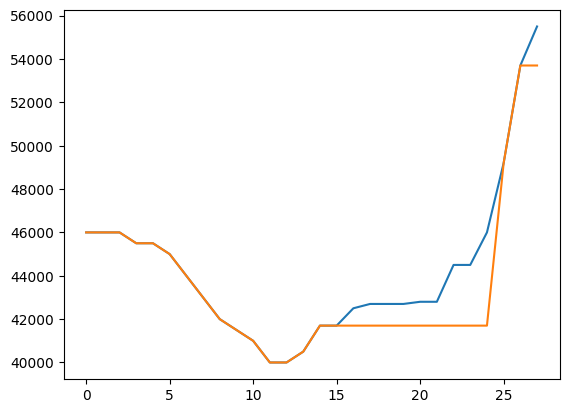

In [13]:
tmp = []
for ob, price in zip(test['Объем'], test['Цена на арматуру']):
    for _ in range(ob):
        tmp.append(price)

test['Цена на арматуру'].plot()
plt.plot(tmp)